In [1]:
import time
import numpy as np
import pandas as pd

import galsim #install with conda install -c conda_forge galsim

import matplotlib.pyplot as plt
from matplotlib import pyplot
import matplotlib.cm as cm
import matplotlib.colors as norm
from matplotlib.gridspec import SubplotSpec
import seaborn as sns

from scipy import stats
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn import svm
from sklearn.svm import SVR

from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.model_selection import cross_validate, KFold, StratifiedKFold
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import cross_val_score
from sklearn.metrics import r2_score
from sklearn.inspection import permutation_importance
from sklearn.pipeline import make_pipeline #This allows one to build different steps together
from sklearn.preprocessing import StandardScaler, RobustScaler

from tqdm import tqdm 

from pysr import PySRRegressor

In [72]:
df_ellipticals.shape

(2422, 33)

In [2]:
df_ellipticals = pd.read_csv('Ellipticals Dataset_as defined in notebook v13')

X_ellipticals = df_ellipticals.drop(columns=['GalpropNormHalfRadius', 'BulgeMstar_ratio'])


y_ellipticals = df_ellipticals.loc[:,'GalpropNormHalfRadius']

# choose only the 4 most important features from feature ranking in notebook v13,
# in order to reduce the time to run SR modelling

In [3]:
X_ellipticals_imp = X_ellipticals.loc[:, ['GalpropNormSigmaBulge', 'GalpropNormMstar',
                                                   'GalpropNormMstar_merge', 'HalopropSpin',
                                                   'HalopropC_nfw', 'GalpropNormMbulge',
                                                   'HalopropMetal_ejected']]


y_ellipticals_imp = y_ellipticals

In [4]:
# choose the Symbolic Regression model; choose the mathematical operations allowed
model_ellipticals_imp = PySRRegressor(
    niterations=10,
    binary_operators=["+", "*", "pow", "/", ],
    unary_operators=["exp", "square", "cube"
#         "inv(x) = 1/x",  # Custom operator (julia syntax)
         ],
        constraints={
        "pow": (-1, 1),
        "/": (-1, 4),
#         "sqrt": 5,
    },
    
    nested_constraints={
        "pow": {"pow": 1, "exp": 0},
    },
    maxsize=30,
    multithreading=False,
    model_selection="best", # Result is mix of simplicity+accuracy
    loss="loss(x, y) = (x - y)^2"  # Custom loss function (julia syntax)

)

In [5]:
start_time = time.time()

model_ellipticals_imp.fit(X_ellipticals_imp, np.array(y_ellipticals_imp))

elapsed_time = time.time() - start_time

print(f"Elapsed time to compute the Ellipticals SymbolicRegression fitting: {elapsed_time:.3f} seconds")

/Users/festabu/miniforge3/envs/native/lib/python3.9/site-packages/pysr/sr.py:1067: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(
  Activating project at `~/.julia/environments/pysr-0.9.3`
    Updating registry at `~/.julia/registries/General.toml`
   Resolving package versions...
  No Changes to `~/.julia/environments/pysr-0.9.3/Project.toml`
  No Changes to `~/.julia/environments/pysr-0.9.3/Manifest.toml`
   Resolving package versions...
  No Changes to `~/.julia/environments/pysr-0.9.3/Project.toml`
  No Changes to `~/.julia/environments/pysr-0.9.3/Manifest.toml`
  No Changes to `~/.julia/environments/pysr-0.9.3/Project.toml`
  No Changes to `~/.julia/environments/pysr-0.9.3/Manifest.toml`


Activating environment on workers.
      From worker 2:	  Activating project at `~/.julia/environments/pysr-0.9.3`
      From worker 9:	  Activating project at `~/.julia/environments/pysr-0.9.3`
      From worker 6:	  Activating project at `~/.julia/environments/pysr-0.9.3`
      From worker 3:	  Activating project at `~/.julia/environments/pysr-0.9.3`
      From worker 5:	  Activating project at `~/.julia/environments/pysr-0.9.3`
      From worker 4:	  Activating project at `~/.julia/environments/pysr-0.9.3`
      From worker 8:	  Activating project at `~/.julia/environments/pysr-0.9.3`
      From worker 7:	  Activating project at `~/.julia/environments/pysr-0.9.3`
Importing installed module on workers...      From worker 2:	WARNING: ignoring conflicting import of CoreModule.div into SymbolicRegression
      From worker 5:	WARNING: ignoring conflicting import of CoreModule.div into SymbolicRegression
      From worker 6:	WARNING: ignoring conflicting import of CoreModule.div into Symb

In [6]:
model_ellipticals_imp.equations_
ellipticals_eqns = model_ellipticals_imp.equations_
# ellipticals_eqns.to_csv('Elliptical_equations_n_iter_1000')

In [7]:
ellipticals_pred = model_ellipticals_imp.predict(X_ellipticals_imp)
ellipticals_pred = pd.DataFrame(ellipticals_pred)
# ellipticals_pred.to_csv('Predicted_elliptical_sizes_SR_n_iter_1000')

In [8]:
print(model_ellipticals_imp.sympy()) # eqn output for Ellipticals with n_iter=10

8.313979/GalpropNormSigmaBulge**2


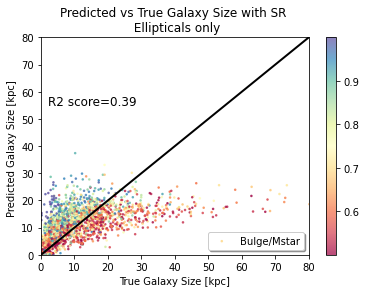

In [10]:
r2_score_ellipticals=r2_score(y_ellipticals_imp, model_ellipticals_imp.predict(X_ellipticals_imp))


plt.scatter(y_ellipticals_imp, model_ellipticals_imp.predict(X_ellipticals_imp),
            c = df_ellipticals['BulgeMstar_ratio'],  cmap='Spectral',
            s=10, marker='.', alpha=0.7, label = 'Bulge/Mstar') #,label= label, vmin=-2, vmax=1.0)
plt.plot([0.0, 150], [0.0, 150], color = 'black', linewidth = 2)
plt.axis([0.0,80, 0.0,80])
plt.text(2, 55, 'R2 score=' + '{:.2f}'.format(r2_score_ellipticals), size=12)
plt.title('Predicted vs True Galaxy Size with SR \n Ellipticals only')
plt.xlabel('True Galaxy Size [kpc]')
plt.ylabel('Predicted Galaxy Size [kpc] ')
plt.legend(loc='lower right' , shadow=True)
plt.colorbar()
# plt.savefig('SR_ellipticals_predicted vs true gal size.jpeg', dpi=500)
plt.show()

In [22]:
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_colwidth', 100)
pd.read_csv('Elliptical_equations_n_iter_1000')

,Unnamed: 0,complexity,loss,score,equation,sympy_format,lambda_format
0,0,1,116.389725,0.000000,9.874922,9.87492200000000,PySRFunction(X=>9.87492200000000)
1,1,3,78.225845,0.198672,(10.61756 / GalpropNormSigmaBulge),10.61756/GalpropNormSigmaBulge,PySRFunction(X=>10.61756/GalpropNormSigmaBulge)
2,2,4,70.560870,0.103124,(8.315446 / square(GalpropNormSigmaBulge)),8.315446/GalpropNormSigmaBulge**2,PySRFunction(X=>8.315446/GalpropNormSigmaBulge**2)
3,3,5,70.147194,0.005880,(68.8238 / square(exp(GalpropNormSigmaBulge))),68.8238*exp(-2*GalpropNormSigmaBulge),PySRFunction(X=>68.8238*exp(-2*GalpropNormSigmaBulge))
4,4,6,63.343636,0.102021,((GalpropNormMstar / cube(GalpropNormSigmaBulge)) * 522.15814),522.15814*GalpropNormMstar/GalpropNormSigmaBulge**3,PySRFunction(X=>522.15814*GalpropNormMstar/GalpropNormSigmaBulge**3)
5,5,7,57.324356,0.099849,"cube(exp(pow(GalpropNormMstar, 0.08628556) / GalpropNormSigmaBulge))",exp(3*Abs(GalpropNormMstar)**0.08628556/GalpropNormSigmaBulge),PySRFunction(X=>exp(3*Abs(GalpropNormMstar)**0.08628556/GalpropNormSigmaBulge))
6,6,8,46.534023,0.208542,"(pow(GalpropNormMstar / -0.0003638138, 0.5725896) / cube(GalpropNormSigmaBulge))",93.1547106650717*Abs(GalpropNormMstar)**0.5725896/GalpropNormSigmaBulge**3,PySRFunction(X=>93.1547106650717*Abs(GalpropNormMstar)**0.5725896/GalpropNormSigmaBulge**3)
7,7,9,45.566288,0.021016,"pow(pow(GalpropNormMstar / GalpropNormSigmaBulge, GalpropNormSigmaBulge) / 0.00071005046, 0.6975...",157.134001677655*Abs(GalpropNormMstar/GalpropNormSigmaBulge)**(0.6975141*re(GalpropNormSigmaBulge)),PySRFunction(X=>157.134001677655*Abs(GalpropNormMstar/GalpropNormSigmaBulge)**(0.6975141*re(Galp...
8,8,10,44.313050,0.027889,"(pow(GalpropNormMstar / -0.00041484096, 0.6101037) / cube(GalpropNormSigmaBulge + GalpropNormMbu...",115.729194673829*Abs(GalpropNormMstar)**0.6101037/(GalpropNormMbulge + GalpropNormSigmaBulge)**3,PySRFunction(X=>115.729194673829*Abs(GalpropNormMstar)**0.6101037/(GalpropNormMbulge + GalpropNo...
9,9,11,33.563620,0.277836,(((GalpropNormMstar / 0.003240377) + cube(GalpropNormMstar / GalpropNormMbulge)) / cube(GalpropN...,(308.606066516334*GalpropNormMstar + GalpropNormMstar**3/GalpropNormMbulge**3)/GalpropNormSigmaB...,PySRFunction(X=>(308.606066516334*GalpropNormMstar + GalpropNormMstar**3/GalpropNormMbulge**3)/G...


In [11]:
# The best SR eqn for Ellipticals (with niter=1000, time=1257 sec) is:
# (308.6*GalpropNormMstar + GalpropNormMstar**3/GalpropNormMbulge**3)/GalpropNormSigmaBulge**3
eqn1 = (308.606066516334*df_ellipticals['GalpropNormMstar']
        + df_ellipticals['GalpropNormMstar']**3/df_ellipticals['GalpropNormMbulge']**3)/df_ellipticals['GalpropNormSigmaBulge']**3

In [12]:
r2_score_disks1=r2_score(y_ellipticals_imp, eqn1)

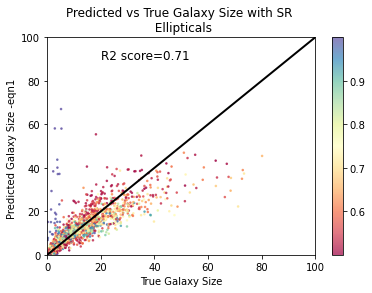

In [13]:
plt.scatter(y_ellipticals_imp, eqn1,
            c = df_ellipticals['BulgeMstar_ratio'],  cmap='Spectral',
            s=10, marker='.', alpha=0.7) #,label= label, vmin=-2, vmax=1.0)
plt.text(20, 90, 'R2 score=' + '{:.2f}'.format(r2_score_disks1), size=12)
plt.plot([0.0, 150], [0.0, 150], color = 'black', linewidth = 2)
plt.axis([0.0,100, 0.0,100])
plt.title('Predicted vs True Galaxy Size with SR \n Ellipticals')
plt.xlabel('True Galaxy Size')
plt.ylabel('Predicted Galaxy Size -eqn1 ')
plt.colorbar()
# plt.savefig('SR_BulgierDisks_predicted vs true gal size.jpeg', dpi=500)
plt.show()

In [16]:
eqn2 = 68.82*np.exp(-2*df_ellipticals['GalpropNormSigmaBulge'])

In [17]:
r2_score_disks2=r2_score(y_ellipticals_imp, eqn2)

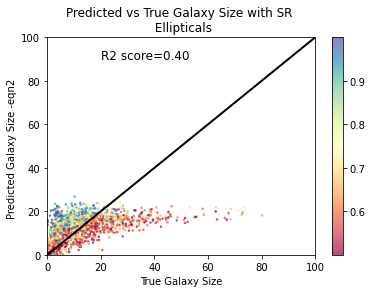

In [19]:
plt.scatter(y_ellipticals_imp, eqn2,
            c = df_ellipticals['BulgeMstar_ratio'],  cmap='Spectral',
            s=10, marker='.', alpha=0.7) #,label= label, vmin=-2, vmax=1.0)
plt.text(20, 90, 'R2 score=' + '{:.2f}'.format(r2_score_disks2), size=12)
plt.plot([0.0, 150], [0.0, 150], color = 'black', linewidth = 2)
plt.axis([0.0,100, 0.0,100])
plt.title('Predicted vs True Galaxy Size with SR \n Ellipticals')
plt.xlabel('True Galaxy Size')
plt.ylabel('Predicted Galaxy Size -eqn2 ')
plt.colorbar()
# plt.savefig('SR_BulgierDisks_predicted vs true gal size.jpeg', dpi=500)
plt.show()

In [23]:
eqn3 = 93.1547106650717*np.abs(df_ellipticals['GalpropNormMstar'])**0.5725896/df_ellipticals['GalpropNormSigmaBulge']**3

In [24]:
r2_score_disks3=r2_score(y_ellipticals_imp, eqn3)

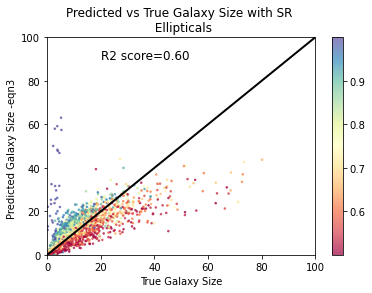

In [27]:
plt.scatter(y_ellipticals_imp, eqn3,
            c = df_ellipticals['BulgeMstar_ratio'],  cmap='Spectral',
            s=10, marker='.', alpha=0.7) #,label= label, vmin=-2, vmax=1.0)
plt.text(20, 90, 'R2 score=' + '{:.2f}'.format(r2_score_disks3), size=12)
plt.plot([0.0, 150], [0.0, 150], color = 'black', linewidth = 2)
plt.axis([0.0,100, 0.0,100])
plt.title('Predicted vs True Galaxy Size with SR \n Ellipticals')
plt.xlabel('True Galaxy Size')
plt.ylabel('Predicted Galaxy Size -eqn3 ')
plt.colorbar()
# plt.savefig('SR_BulgierDisks_predicted vs true gal size.jpeg', dpi=500)
plt.show()

In [28]:
eqn4 = 115.729194673829*np.abs(df_ellipticals['GalpropNormMstar'])**0.6101037/(df_ellipticals['GalpropNormMbulge'] + df_ellipticals['GalpropNormSigmaBulge'])**3

In [29]:
r2_score_disks4=r2_score(y_ellipticals_imp, eqn4)

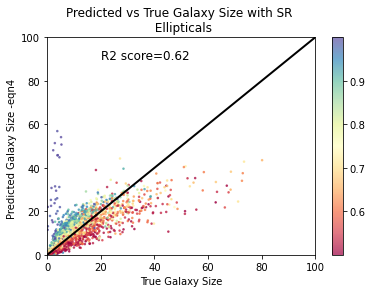

In [30]:
plt.scatter(y_ellipticals_imp, eqn4,
            c = df_ellipticals['BulgeMstar_ratio'],  cmap='Spectral',
            s=10, marker='.', alpha=0.7) #,label= label, vmin=-2, vmax=1.0)
plt.text(20, 90, 'R2 score=' + '{:.2f}'.format(r2_score_disks4), size=12)
plt.plot([0.0, 150], [0.0, 150], color = 'black', linewidth = 2)
plt.axis([0.0,100, 0.0,100])
plt.title('Predicted vs True Galaxy Size with SR \n Ellipticals')
plt.xlabel('True Galaxy Size')
plt.ylabel('Predicted Galaxy Size -eqn4 ')
plt.colorbar()
# plt.savefig('SR_BulgierDisks_predicted vs true gal size.jpeg', dpi=500)
plt.show()

In [31]:
eqn5 = 522.15814*df_ellipticals['GalpropNormMstar']/df_ellipticals['GalpropNormSigmaBulge']**3

In [34]:
r2_score_disks5=r2_score(y_ellipticals_imp, eqn5)

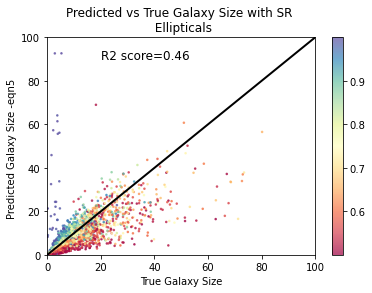

In [35]:
plt.scatter(y_ellipticals_imp, eqn5,
            c = df_ellipticals['BulgeMstar_ratio'],  cmap='Spectral',
            s=10, marker='.', alpha=0.7) #,label= label, vmin=-2, vmax=1.0)
plt.text(20, 90, 'R2 score=' + '{:.2f}'.format(r2_score_disks5), size=12)
plt.plot([0.0, 150], [0.0, 150], color = 'black', linewidth = 2)
plt.axis([0.0,100, 0.0,100])
plt.title('Predicted vs True Galaxy Size with SR \n Ellipticals')
plt.xlabel('True Galaxy Size')
plt.ylabel('Predicted Galaxy Size -eqn5 ')
plt.colorbar()
# plt.savefig('SR_BulgierDisks_predicted vs true gal size.jpeg', dpi=500)
plt.show()

In [36]:
# Best SR eqn for Ellipticals (with niter=15000, time=14441.4 sec) is: 1111.70006510116*Abs(GalpropNormMbulge - 1.0620177*GalpropNormMstar)**GalpropNormSigmaBulge
eqn6 = 1111.7*np.abs(df_ellipticals['GalpropNormMbulge'] - 1.062*df_ellipticals['GalpropNormMstar'])**df_ellipticals['GalpropNormSigmaBulge']

In [39]:
r2_score_disks6=r2_score(y_ellipticals_imp, eqn6)

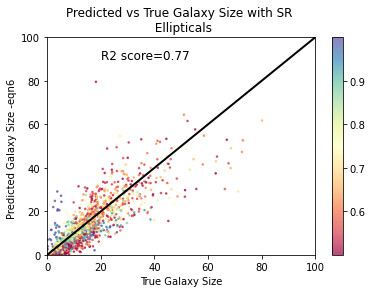

In [41]:
plt.scatter(y_ellipticals_imp, eqn6,
            c = df_ellipticals['BulgeMstar_ratio'],  cmap='Spectral',
            s=10, marker='.', alpha=0.7) #,label= label, vmin=-2, vmax=1.0)
plt.text(20, 90, 'R2 score=' + '{:.2f}'.format(r2_score_disks6), size=12)
plt.plot([0.0, 150], [0.0, 150], color = 'black', linewidth = 2)
plt.axis([0.0,100, 0.0,100])
plt.title('Predicted vs True Galaxy Size with SR \n Ellipticals')
plt.xlabel('True Galaxy Size')
plt.ylabel('Predicted Galaxy Size -eqn6 ')
plt.colorbar()
# plt.savefig('Ellipticals_SR_eqn6_vs_true_gal_size.jpeg', dpi=500)
plt.show()

In [42]:
# Best SR eqn for Ellipticals w Bulge/Mstar feature added(with niter=20, time=179.4 sec) is:
#(109.702541889589*Abs(GalpropNormMstar)**BulgeMstar_ratio + 1.97220178845976)/GalpropNormSigmaBulge**3
# The R2=0.76 for this eqn
eqn7 = (109.7*np.abs(df_ellipticals['GalpropNormMstar'])**df_ellipticals['BulgeMstar_ratio'] + 1.97220178845976)/df_ellipticals['GalpropNormSigmaBulge']**3

In [43]:
r2_score_disks7=r2_score(y_ellipticals_imp, eqn7)

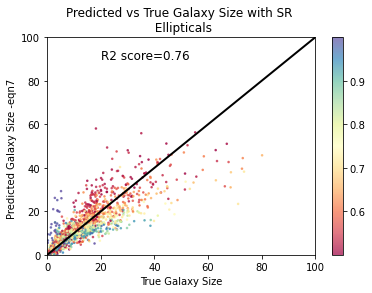

In [44]:
plt.scatter(y_ellipticals_imp, eqn7,
            c = df_ellipticals['BulgeMstar_ratio'],  cmap='Spectral',
            s=10, marker='.', alpha=0.7) #,label= label, vmin=-2, vmax=1.0)
plt.text(20, 90, 'R2 score=' + '{:.2f}'.format(r2_score_disks7), size=12)
plt.plot([0.0, 150], [0.0, 150], color = 'black', linewidth = 2)
plt.axis([0.0,100, 0.0,100])
plt.title('Predicted vs True Galaxy Size with SR \n Ellipticals')
plt.xlabel('True Galaxy Size')
plt.ylabel('Predicted Galaxy Size -eqn7 ')
plt.colorbar()
# plt.savefig('Ellipticals_SR_eqn6_vs_true_gal_size.jpeg', dpi=500)
plt.show()

In [46]:
eqn8 = 8.32/df_ellipticals['GalpropNormSigmaBulge']**2

In [47]:
r2_score_disks8=r2_score(y_ellipticals_imp, eqn8)

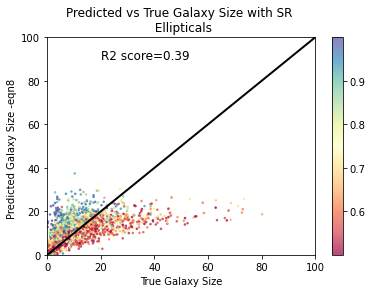

In [48]:
plt.scatter(y_ellipticals_imp, eqn8,
            c = df_ellipticals['BulgeMstar_ratio'],  cmap='Spectral',
            s=10, marker='.', alpha=0.7) #,label= label, vmin=-2, vmax=1.0)
plt.text(20, 90, 'R2 score=' + '{:.2f}'.format(r2_score_disks8), size=12)
plt.plot([0.0, 150], [0.0, 150], color = 'black', linewidth = 2)
plt.axis([0.0,100, 0.0,100])
plt.title('Predicted vs True Galaxy Size with SR \n Ellipticals')
plt.xlabel('True Galaxy Size')
plt.ylabel('Predicted Galaxy Size -eqn8 ')
plt.colorbar()
# plt.savefig('Ellipticals_SR_eqn6_vs_true_gal_size.jpeg', dpi=500)
plt.show()

In [50]:
#2.23121403705558*(0.765278634889849*log(45.46777*Abs(GalpropNormMstar) + 1) + 1)**3/(BulgeMstar_ratio*GalpropNormSigmaBulge**3)
eqn9 = 2.23*(0.76*np.log(45.47*np.abs(df_ellipticals['GalpropNormMstar']) + 1) + 1)**3/(df_ellipticals['BulgeMstar_ratio']*df_ellipticals['GalpropNormSigmaBulge']**3)


In [51]:
r2_score_disks9=r2_score(y_ellipticals_imp, eqn9)

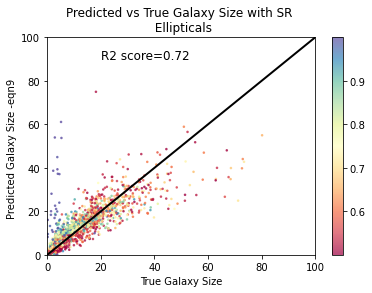

In [52]:
plt.scatter(y_ellipticals_imp, eqn9,
            c = df_ellipticals['BulgeMstar_ratio'],  cmap='Spectral',
            s=10, marker='.', alpha=0.7) #,label= label, vmin=-2, vmax=1.0)
plt.text(20, 90, 'R2 score=' + '{:.2f}'.format(r2_score_disks9), size=12)
plt.plot([0.0, 150], [0.0, 150], color = 'black', linewidth = 2)
plt.axis([0.0,100, 0.0,100])
plt.title('Predicted vs True Galaxy Size with SR \n Ellipticals')
plt.xlabel('True Galaxy Size')
plt.ylabel('Predicted Galaxy Size -eqn9 ')
plt.colorbar()
# plt.savefig('Ellipticals_SR_eqn6_vs_true_gal_size.jpeg', dpi=500)
plt.show()

In [53]:
# log(1758836.02776097*Abs(GalpropNormMstar**2) + 1)/(BulgeMstar_ratio*GalpropNormSigmaBulge**3)
eqn10 = np.log(1758836.02*np.abs(df_ellipticals['GalpropNormMstar']**2) + 1)/(df_ellipticals['BulgeMstar_ratio']*df_ellipticals['GalpropNormSigmaBulge']**3)


In [54]:
r2_score_disks10=r2_score(y_ellipticals_imp, eqn10)

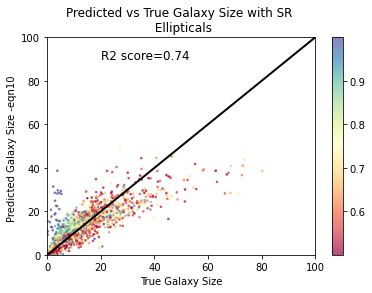

In [55]:
plt.scatter(y_ellipticals_imp, eqn10,
            c = df_ellipticals['BulgeMstar_ratio'],  cmap='Spectral',
            s=10, marker='.', alpha=0.7) #,label= label, vmin=-2, vmax=1.0)
plt.text(20, 90, 'R2 score=' + '{:.2f}'.format(r2_score_disks10), size=12)
plt.plot([0.0, 150], [0.0, 150], color = 'black', linewidth = 2)
plt.axis([0.0,100, 0.0,100])
plt.title('Predicted vs True Galaxy Size with SR \n Ellipticals')
plt.xlabel('True Galaxy Size')
plt.ylabel('Predicted Galaxy Size -eqn10 ')
plt.colorbar()
# plt.savefig('Ellipticals_SR_eqn6_vs_true_gal_size.jpeg', dpi=500)
plt.show()

In [69]:
# The best eqn output with n_iter=7,000 and features: ['GalpropNormSigmaBulge', 'GalpropNormMstar_merge', 'HalopropSpin', 'HalopropC_nfw', 'HalopropMetal_ejected', 'BulgeMstar_ratio']
# (that is, Mstar and Mbulge are not present as independent features, but only as a ratio in BulgeMstar_ratio)
#291.29834*Abs(GalpropNormMstar_merge)**BulgeMstar_ratio/GalpropNormSigmaBulge**3

eqn11 = 291.3*np.abs(df_ellipticals['GalpropNormMstar_merge'])**df_ellipticals['BulgeMstar_ratio']/df_ellipticals['GalpropNormSigmaBulge']**3

In [70]:
r2_score_disks11=r2_score(y_ellipticals_imp, eqn11)

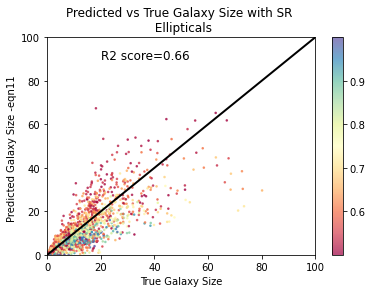

In [71]:
plt.scatter(y_ellipticals_imp, eqn11,
            c = df_ellipticals['BulgeMstar_ratio'],  cmap='Spectral',
            s=10, marker='.', alpha=0.7) #,label= label, vmin=-2, vmax=1.0)
plt.text(20, 90, 'R2 score=' + '{:.2f}'.format(r2_score_disks11), size=12)
plt.plot([0.0, 150], [0.0, 150], color = 'black', linewidth = 2)
plt.axis([0.0,100, 0.0,100])
plt.title('Predicted vs True Galaxy Size with SR \n Ellipticals')
plt.xlabel('True Galaxy Size')
plt.ylabel('Predicted Galaxy Size -eqn11 ')
plt.colorbar()
# plt.savefig('Ellipticals_SR_eqn6_vs_true_gal_size.jpeg', dpi=500)
plt.show()

In [59]:
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_colwidth', 500)
pd.read_csv('Elliptical_equations_n_iter_7000')

,Unnamed: 0,complexity,loss,score,equation,sympy_format,lambda_format
0,0,1,116.389725,0.000000,9.874919,9.87491900000000,PySRFunction(X=>9.87491900000000)
1,1,3,78.225845,0.198672,(10.617563 / GalpropNormSigmaBulge),10.617563/GalpropNormSigmaBulge,PySRFunction(X=>10.617563/GalpropNormSigmaBulge)
2,2,4,70.560870,0.103124,(8.315536 / square(GalpropNormSigmaBulge)),8.315536/GalpropNormSigmaBulge**2,PySRFunction(X=>8.315536/GalpropNormSigmaBulge**2)
3,3,5,69.049360,0.021654,((7.5458136 / BulgeMstar_ratio) / GalpropNormSigmaBulge),7.5458136/(BulgeMstar_ratio*GalpropNormSigmaBulge),PySRFunction(X=>7.5458136/(BulgeMstar_ratio*GalpropNormSigmaBulge))
4,4,6,54.438015,0.237759,"pow(log1p_abs(BulgeMstar_ratio) * GalpropNormSigmaBulge, -2.83)",1/(log(Abs(BulgeMstar_ratio) + 1)**2.83*Abs(GalpropNormSigmaBulge)**2.83),PySRFunction(X=>1/(log(Abs(BulgeMstar_ratio) + 1)**2.83*Abs(GalpropNormSigmaBulge)**2.83))
5,5,7,53.089977,0.025075,"(pow(log1p_abs(GalpropNormSigmaBulge), -3.3640347) / square(BulgeMstar_ratio))",1/(BulgeMstar_ratio**2*log(Abs(GalpropNormSigmaBulge) + 1)**3.3640347),PySRFunction(X=>1/(BulgeMstar_ratio**2*log(Abs(GalpropNormSigmaBulge) + 1)**3.3640347))
6,6,8,39.938606,0.284645,"(pow(GalpropNormMstar_merge, BulgeMstar_ratio) / (cube(GalpropNormSigmaBulge) / 291.29834))",291.29834*Abs(GalpropNormMstar_merge)**BulgeMstar_ratio/GalpropNormSigmaBulge**3,PySRFunction(X=>291.29834*Abs(GalpropNormMstar_merge)**BulgeMstar_ratio/GalpropNormSigmaBulge**3)
7,7,9,38.782410,0.029377,"(log1p_abs(pow(GalpropNormMstar_merge, BulgeMstar_ratio) / cube(GalpropNormSigmaBulge)) / 0.0032647927)",306.298160982778*log(Abs(GalpropNormMstar_merge)**re(BulgeMstar_ratio)*Abs(GalpropNormSigmaBulge**(-3)) + 1),PySRFunction(X=>306.298160982778*log(Abs(GalpropNormMstar_merge)**re(BulgeMstar_ratio)*Abs(GalpropNormSigmaBulge**(-3)) + 1))
8,8,10,33.267220,0.153394,"((pow(GalpropNormMstar_merge, BulgeMstar_ratio) + 0.008803189) / (cube(GalpropNormSigmaBulge) / 223.52284))",223.52284*(Abs(GalpropNormMstar_merge)**BulgeMstar_ratio + 0.008803189)/GalpropNormSigmaBulge**3,PySRFunction(X=>223.52284*(Abs(GalpropNormMstar_merge)**BulgeMstar_ratio + 0.008803189)/GalpropNormSigmaBulge**3)
9,9,11,32.272774,0.030349,"(log1p_abs(pow(GalpropNormMstar_merge, BulgeMstar_ratio) / 0.016949806) / (cube(GalpropNormSigmaBulge) * 0.1094773))",9.13431368877384*log(58.9977254016949*Abs(GalpropNormMstar_merge)**re(BulgeMstar_ratio) + 1)/GalpropNormSigmaBulge**3,PySRFunction(X=>9.13431368877384*log(58.9977254016949*Abs(GalpropNormMstar_merge)**re(BulgeMstar_ratio) + 1)/GalpropNormSigmaBulge**3)
